In [1]:
! pip install tensorflow==1.13.1
! pip install tensorflow-gpu==1.13.1
! pip install keras==2.1.2
! pip install imutils

You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
# ça prend trop de temps de charger les données d'image directement de S3 
# Ecrire directement la ligne de commande suivante pour charger les données de S3 au répertoire de SagaMaker  : 
# aws s3 cp --recursive s3://chau-testbucket/dataset/training_set/cats /home/ec2-user/SageMaker/cats # 

In [3]:
import keras
import boto3
import os
import cv2
import numpy as np
import pandas as pd
from imutils import paths
from keras.models import load_model, Model
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image
import matplotlib.image as mpimg
%matplotlib inline
from keras.utils import np_utils
from keras.models import Sequential
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import keras_preprocessing.image.image_data_generator
from keras.preprocessing.image import ImageDataGenerator
from imutils import paths
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import metrics
import random 
import os
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.layers.core import Flatten
#from keras.layers.core import Convolution2D
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from keras.applications import imagenet_utils
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras.applications.mobilenet import MobileNet

Using TensorFlow backend.


In [59]:
# Importer de fichier des features  #
df2 = pd.read_csv("data.csv")
# Examiner les valeurs NA dans chaque variable #
num_sum = df2.isna().sum()
num_sum

Unnamed: 0               0
lien                     0
name                     0
matiere               1510
coupe_type             584
motifCouleur           414
longueurDesManches      82
categorie                0
long                    69
dtype: int64

In [60]:
# Drop les lignes NA #
df2 = df2.dropna()
print(df2.shape) # Il reste encore 1675 lignes après avoir nettoyé les valeurs NA #

(1675, 9)


In [61]:
# Créer une variable label qui est combinaison entre les 2 features "motif couleur" et le type de "longeur" # 
df2["label"] = df2["motifCouleur"].str.cat(df2["long"],sep ="-")

In [62]:
df2.head()

Unnamed: 0                                               lien       name  \
1            1  /home/ec2-user/SageMaker/fashion_robe_2/images...  dp521c1py   
3            3  /home/ec2-user/SageMaker/fashion_robe_2/images...  ve121c1mu   
11          11  /home/ec2-user/SageMaker/fashion_robe_2/images...  ya021c01u   
17          17  /home/ec2-user/SageMaker/fashion_robe_2/images...  b0m21c04q   
20          20  /home/ec2-user/SageMaker/fashion_robe_2/images...  lar21c019   

       matiere     coupe_type    motifCouleur    longueurDesManches  \
1       Jersey  Près du corps  Imprimé animal       Manches longues   
3       Jersey  Près du corps         Rayures       Manches longues   
11      Jersey  Près du corps           Chiné       Manches longues   
17  Mousseline  Près du corps         Imprimé       Manches longues   
20      Jersey        Normale    Couleur unie  Manches trois-quarts   

              categorie              long                            label  
1   robes-foureau-femme  Jusqu'aux genoux  Imprimé animal-Jusqu'aux genoux  
3   robes-foureau-femme            Courte                   Rayures-Courte  
11  robes-foureau-femme  Jusqu'aux genoux           Chiné-Jusqu'aux genoux  
17  robes-foureau-femme            Courte                   Imprimé-Courte  
20  robes-t-shirt-femme  Jusqu'aux genoux    Couleur unie-Jusqu'aux genoux

In [63]:
df2["long"].value_counts()

Jusqu'aux genoux    501
Courte              417
Longue              297
Longueur midi       275
Extra courte        185
Name: long, dtype: int64

In [65]:
df2["label2"] = df2["motifCouleur"].str.cat(df2["long2"],sep ="-")

In [66]:
(df2["label"].value_counts()).count() # 52 combinaison #

52

In [67]:
df2["label"].value_counts()

Couleur unie-Jusqu'aux genoux         299
Couleur unie-Courte                   243
Couleur unie-Longue                   181
Couleur unie-Longueur midi            144
Couleur unie-Extra courte             122
Floral-Jusqu'aux genoux                58
Floral-Longue                          58
Chiné-Courte                           52
Chiné-Jusqu'aux genoux                 47
Rayures-Jusqu'aux genoux               46
Floral-Longueur midi                   34
Rayures-Courte                         31
Imprimé-Jusqu'aux genoux               29
Floral-Courte                          27
Chiné-Longueur midi                    25
Imprimé-Courte                         25
Rayures-Longueur midi                  24
Chiné-Extra courte                     18
Imprimé-Longue                         15
Imprimé animal-Longueur midi           14
Floral-Extra courte                    14
Imprimé-Longueur midi                  13
Imprimé animal-Courte                  12
À pois-Courte                     

In [71]:
# Data processing end #
df2.head()

Unnamed: 0                                               lien       name  \
1            1  /home/ec2-user/SageMaker/fashion_robe_2/images...  dp521c1py   
3            3  /home/ec2-user/SageMaker/fashion_robe_2/images...  ve121c1mu   
11          11  /home/ec2-user/SageMaker/fashion_robe_2/images...  ya021c01u   
17          17  /home/ec2-user/SageMaker/fashion_robe_2/images...  b0m21c04q   
20          20  /home/ec2-user/SageMaker/fashion_robe_2/images...  lar21c019   

       matiere     coupe_type    motifCouleur    longueurDesManches  \
1       Jersey  Près du corps  Imprimé animal       Manches longues   
3       Jersey  Près du corps         Rayures       Manches longues   
11      Jersey  Près du corps           Chiné       Manches longues   
17  Mousseline  Près du corps         Imprimé       Manches longues   
20      Jersey        Normale    Couleur unie  Manches trois-quarts   

              categorie              long                            label  \
1   robes-foureau-femme  Jusqu'aux genoux  Imprimé animal-Jusqu'aux genoux   
3   robes-foureau-femme            Courte                   Rayures-Courte   
11  robes-foureau-femme  Jusqu'aux genoux           Chiné-Jusqu'aux genoux   
17  robes-foureau-femme            Courte                   Imprimé-Courte   
20  robes-t-shirt-femme  Jusqu'aux genoux    Couleur unie-Jusqu'aux genoux   

               long2                           label2  
1   Jusqu'aux genoux  Imprimé animal-Jusqu'aux genoux  
3             Courte                   Rayures-Courte  
11  Jusqu'aux genoux           Chiné-Jusqu'aux genoux  
17            Courte                   Imprimé-Courte  
20  Jusqu'aux genoux    Couleur unie-Jusqu'aux genoux

# Fine_tuning VGG16  #

In [72]:
# Label #
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

# Convestir le nom des catérogies en numérique 
le = LabelEncoder()
labels = le.fit_transform(df2["label"])

# One-hot encoding
lb = LabelBinarizer()
labels = lb.fit_transform(df2["label"])

In [73]:
labels.shape # 1675 - 52 catérogies #

(1675, 52)

In [74]:
# Importer VGG 16 
vgg16 = keras.applications.vgg16

# Appeler le modèle de VGG 16, le paralètre include_top=False pour dire qu'on prend pas le dernier
# couche de sortie de VGG 16 #
base_model = vgg16.VGG16(weights='imagenet',include_top=False,input_shape = (224,224,3)) 
base_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
bloc

In [75]:
# Ajouter les couches cachés #

# Prendre output de dernier couche de ConvNet dans VGG16
fcHead = base_model.output

# Flatten de dernier couche de ConvNet de VGG 16 #
fcHead = Flatten(name='flatten')(fcHead)

# Ajouter des couches Fully Connected
fcHead = Dense(1024, activation='relu')(fcHead)
fcHead = Dense(512, activation='relu')(fcHead)
fcHead = Dense(256, activation='relu')(fcHead)
fcHead = Dense(125, activation='relu')(fcHead)


# Couche sortie avec la fonction softmax activation
fcHead = Dense(52, activation='softmax')(fcHead)

# Le nouveau modèle est une combinaison entre les couches ConvNet de VGG16 et  fcHead
model = model = Model(inputs=base_model.input, outputs=fcHead)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [76]:

# Lire des images de notre dataset et resize ces images en tailles VGG 16 besoin : 
list_image = []
for (j, imagePath) in enumerate(df2["lien"].to_list()):
    
    # Load image et resize les images convient aux size (224,224) commne VGG 16 #
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    
    #
    image = np.expand_dims(image, 0)
    image = imagenet_utils.preprocess_input(image) # encoding image #
    
    list_image.append(image)
    
list_image = np.vstack(list_image)

In [77]:
#  Créer la fonction d'augementation de taille de train_dataset # 
from keras.preprocessing.image import ImageDataGenerator
aug_train = ImageDataGenerator(rescale=1./255, rotation_range=30, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.2, 
                         zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')

# Créer la fonction d'augmentation de taille de test_dataset #
aug_test= ImageDataGenerator(rescale=1./255)

In [78]:
# Géler sur l'ensemble de couches de VGG 16, entrainer que les dernier couches ajoutées #
for layer in base_model.layers:
    layer.trainable = False
model.compile(loss='categorical_crossentropy',
                     optimizer='adam',
                     metrics=['accuracy'])

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [79]:
# Augemnatation de taille train_dataset et testdataset, ensuite entrainer #
model.fit_generator(aug_train.flow(list_image,labels, batch_size=32), 
                        steps_per_epoch=len(list_image)//32,
                        epochs=25)
# On voit bien de l'accuracy augemente au cours des épochs #

Instructions for updating:
Use tf.cast instead.
Epoch 1/25
52/52 [==============================] - 13s 249ms/step - loss: 3.2682 - acc: 0.1788
Epoch 2/25
52/52 [==============================] - 12s 231ms/step - loss: 2.5104 - acc: 0.2852
Epoch 3/25
52/52 [==============================] - 12s 231ms/step - loss: 2.3043 - acc: 0.3249
Epoch 4/25
52/52 [==============================] - 12s 230ms/step - loss: 2.1599 - acc: 0.3640
Epoch 5/25
52/52 [==============================] - 12s 232ms/step - loss: 2.0749 - acc: 0.3737
Epoch 6/25
52/52 [==============================] - 12s 233ms/step - loss: 1.9826 - acc: 0.3917
Epoch 7/25
52/52 [==============================] - 12s 232ms/step - loss: 1.8811 - acc: 0.4211
Epoch 8/25
52/52 [==============================] - 12s 233ms/step - loss: 1.8652 - acc: 0.4050
Epoch 9/25
52/52 [==============================] - 12s 231ms/step - loss: 1.8217 - acc: 0.4516
Epoch 10/25
52/52 [==============================] - 12s 229ms/step - loss: 1.7190 - acc

In [80]:
# Léger les 15 premiers couches, entrainer le deuxièle fois le modèle à partir de 16 couches de VGG 16  #
# et les nouveaux couches FC ajoutées #
for layer in model.layers[:15]:
    layer.trainable = False
#model.summary()

In [81]:
# Compier le modèle #
model.compile(loss='categorical_crossentropy',
                     optimizer='rmsprop',
                     metrics=['accuracy'])

In [82]:
# On voit bien de l'accuracy de modèle améliore #
model.fit_generator(aug_train.flow(list_image,labels, batch_size=32), 
                        steps_per_epoch=len(list_image)//32,
                        epochs=25)

Epoch 1/25
52/52 [==============================] - 12s 233ms/step - loss: 1.7068 - acc: 0.4961
Epoch 2/25
52/52 [==============================] - 12s 231ms/step - loss: 1.4920 - acc: 0.5224
Epoch 3/25
52/52 [==============================] - 12s 232ms/step - loss: 1.4091 - acc: 0.5353
Epoch 4/25
52/52 [==============================] - 12s 233ms/step - loss: 1.3953 - acc: 0.5488
Epoch 5/25
52/52 [==============================] - 12s 234ms/step - loss: 1.3034 - acc: 0.5727
Epoch 6/25
52/52 [==============================] - 12s 229ms/step - loss: 1.3669 - acc: 0.5595
Epoch 7/25
52/52 [==============================] - 12s 234ms/step - loss: 1.3159 - acc: 0.5687
Epoch 8/25
52/52 [==============================] - 12s 232ms/step - loss: 1.2864 - acc: 0.5731
Epoch 9/25
52/52 [==============================] - 12s 231ms/step - loss: 1.3377 - acc: 0.5514
Epoch 10/25
52/52 [==============================] - 12s 232ms/step - loss: 1.2076 - acc: 0.5896
Epoch 11/25
52/52 [====================

In [130]:
# Sauvegarder le point de terminaison du modèle modèle #
model.save("model_{}categ_full.h5".format(len(labels)))

In [84]:
# Créer un modèle intermédiaire qui prend la sortie est 
# l'avant de dernière couche du modèle déjà entrainé # 
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=[model.layers[-2].output])

In [131]:
intermediate_layer_model.save("intermediarie_model_{}categ_full.h5".format(len(labels)))

In [85]:
# Extract des features de nouveau modèle #
features = intermediate_layer_model.predict(list_image)

In [86]:
# Lancer K_Means # 
kmeans = KMeans(n_clusters=13, random_state=0,init='k-means++',max_iter=200).fit(features)
# Résultat de K_Means label #
print(kmeans.labels_)

[ 9  5  0 ... 12  0  0]


In [87]:
n_clusters = 13
cluster_path ='/home/ec2-user/SageMaker/robe_clustering_bis/'

In [88]:
# Créer des répertoires des images #
for c in range(0,n_clusters):
    if not os.path.exists(cluster_path+'cluster_'+str(c)):
        os.mkdir(cluster_path+'cluster_'+str(c))

In [89]:
# Sauvegarder les images dans le répertoire de cluster correspondant #
for fn, cluster in zip(df2["lien"].to_list(),kmeans.labels_): 
    image = cv2.imread(fn)
    cv2.imwrite(cluster_path+'cluster_'+str(cluster)+'/'+fn.split("/")[-1],image)

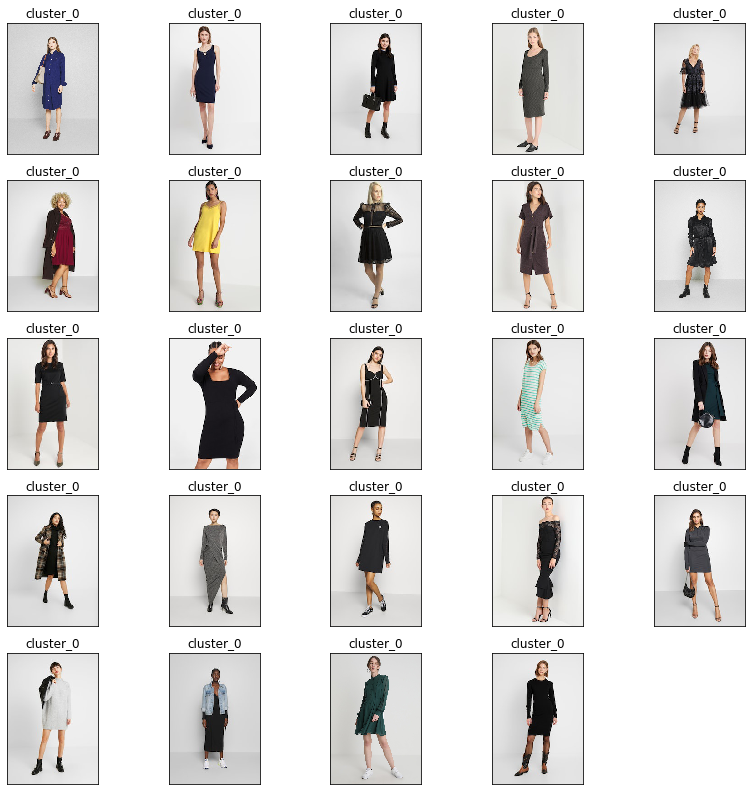

In [129]:
fig = plt.figure(figsize=(14, 14))
cluster_path = '/home/ec2-user/SageMaker/robe_clustering_bis//cluster_0/'
images = [file for file in os.listdir(cluster_path)]

for cnt, data in enumerate(images[1:25]):
#     print(data)
    y = fig.add_subplot(5,5,cnt+1)
    img = mpimg.imread(cluster_path+data) #Read an image from a file into an array.
    y.imshow(img)
    plt.title('cluster_0')
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)

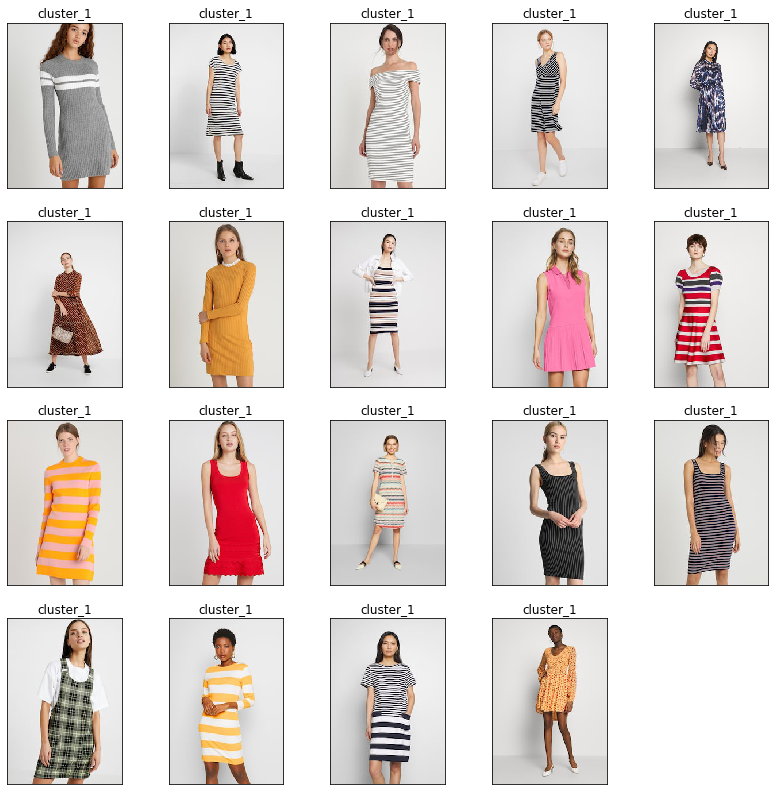

In [91]:
fig = plt.figure(figsize=(14, 14))
cluster_path = '/home/ec2-user/SageMaker/robe_clustering_bis//cluster_1/'
images = [file for file in os.listdir(cluster_path)]

for cnt, data in enumerate(images[1:20]):
#     print(data)
    y = fig.add_subplot(4,5, cnt+1)
    img = mpimg.imread(cluster_path+data) #Read an image from a file into an array.
    y.imshow(img)
    plt.title('cluster_1')
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)

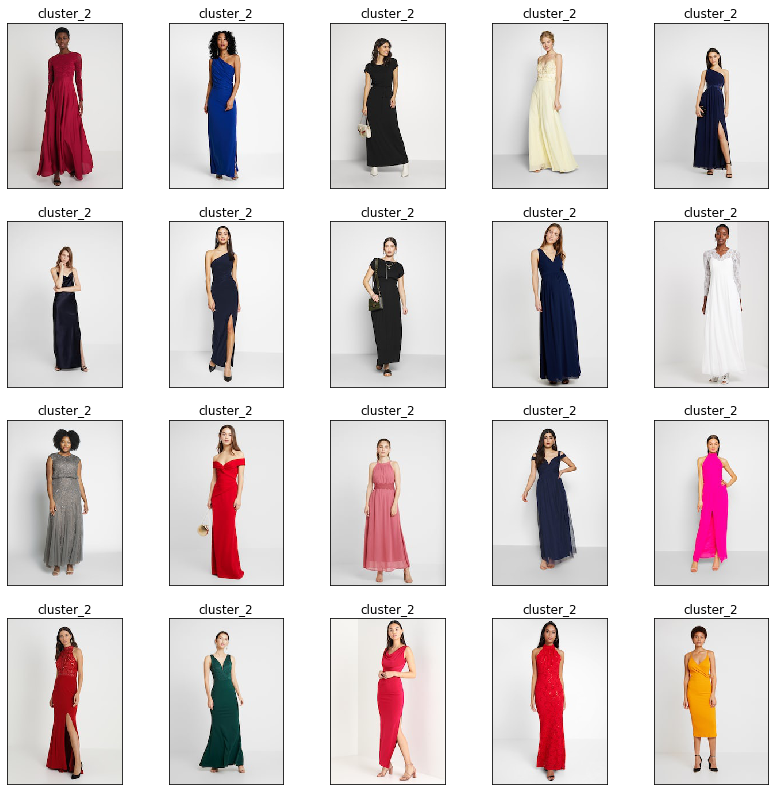

In [125]:
fig = plt.figure(figsize=(14, 14))
cluster_path = '/home/ec2-user/SageMaker/robe_clustering_bis/cluster_2/'
images = [file for file in os.listdir(cluster_path)]

for cnt, data in enumerate(images[1:21]):
#     print(data)
    y = fig.add_subplot(4,5, cnt+1)
    img = mpimg.imread(cluster_path+data) #Read an image from a file into an array.
    y.imshow(img)
    plt.title('cluster_2')
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)

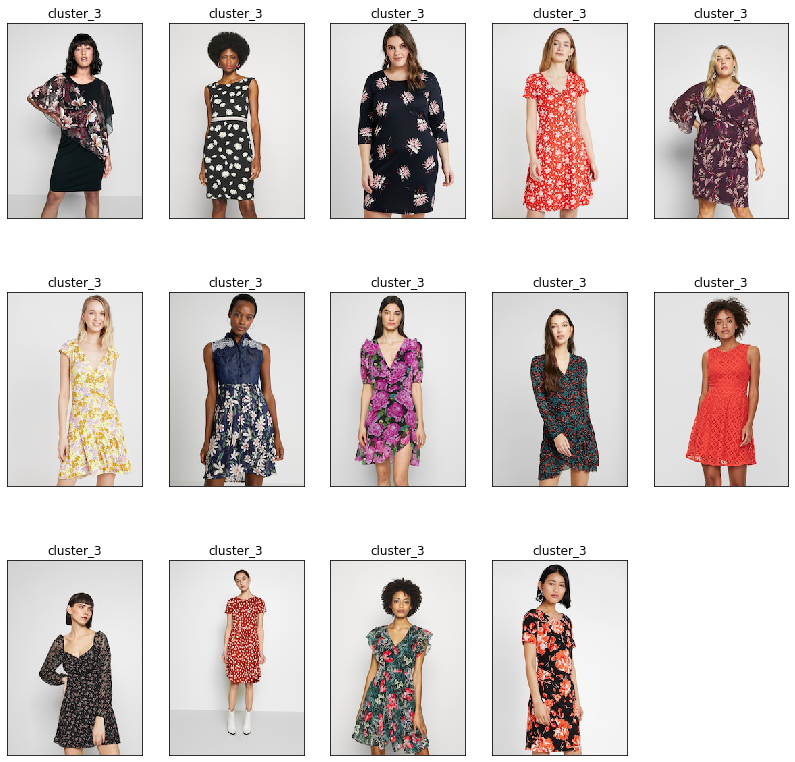

In [124]:
fig = plt.figure(figsize=(14, 14))
cluster_path = '/home/ec2-user/SageMaker/robe_clustering_bis//cluster_3/'
images = [file for file in os.listdir(cluster_path)]

for cnt, data in enumerate(images[1:15]):
#     print(data)
    y = fig.add_subplot(3,5, cnt+1)
    img = mpimg.imread(cluster_path+data) #Read an image from a file into an array.
    y.imshow(img)
    plt.title('cluster_3')
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)

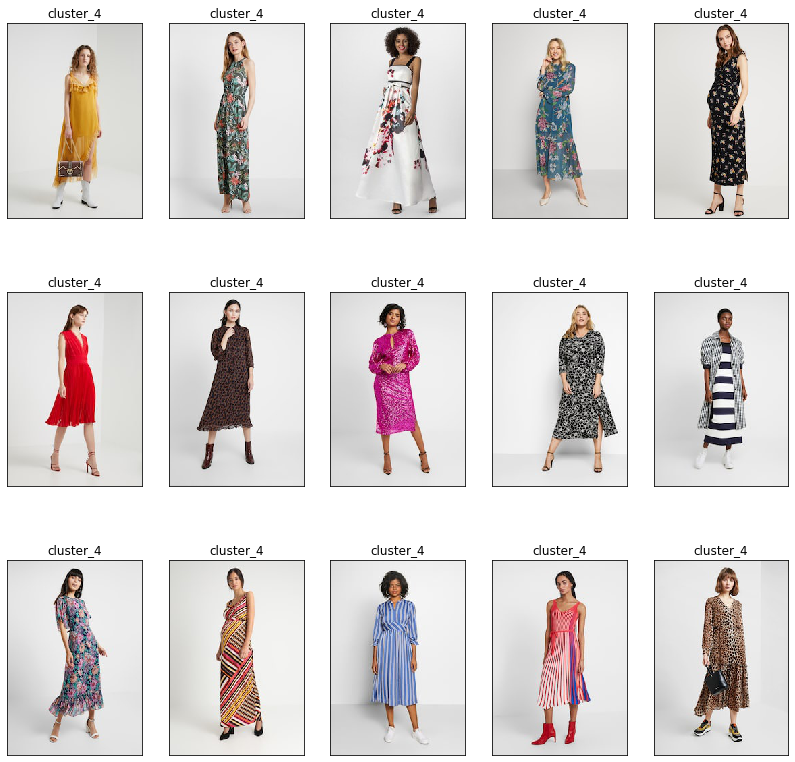

In [103]:
fig = plt.figure(figsize=(14, 14))
cluster_path = '/home/ec2-user/SageMaker/robe_clustering_bis/cluster_4/'
images = [file for file in os.listdir(cluster_path)]

for cnt, data in enumerate(images[1:16]):
#     print(data)
    y = fig.add_subplot(3,5, cnt+1)
    img = mpimg.imread(cluster_path+data) #Read an image from a file into an array.
    y.imshow(img)
    plt.title('cluster_4')
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)

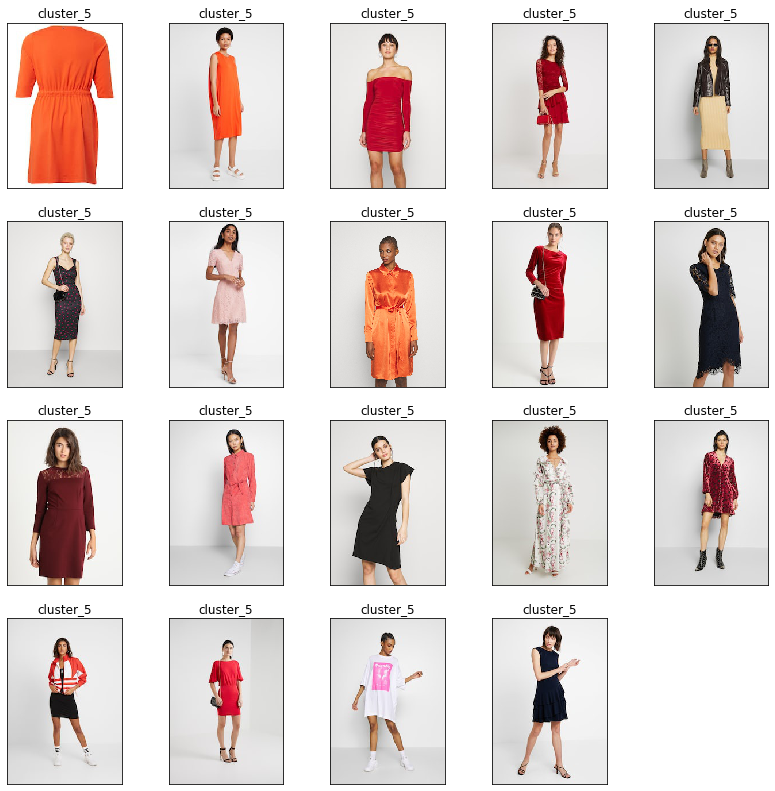

In [105]:
fig = plt.figure(figsize=(14, 14))
cluster_path = '/home/ec2-user/SageMaker/robe_clustering_bis/cluster_5/'
images = [file for file in os.listdir(cluster_path)]

for cnt, data in enumerate(images[1:20]):
#     print(data)
    y = fig.add_subplot(4,5, cnt+1)
    img = mpimg.imread(cluster_path+data) #Read an image from a file into an array.
    y.imshow(img)
    plt.title('cluster_5')
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)

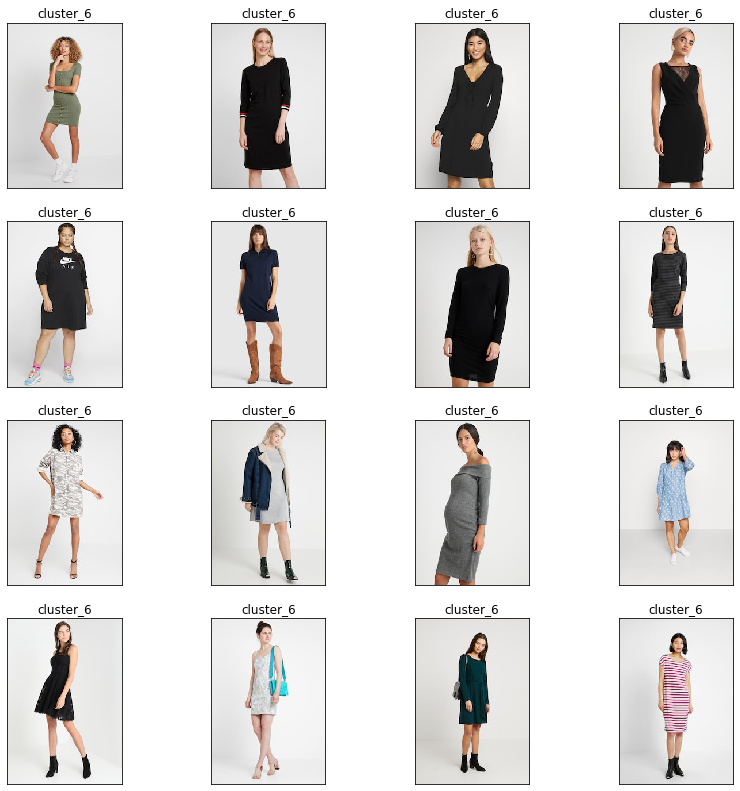

In [106]:
fig = plt.figure(figsize=(14, 14))
cluster_path = '/home/ec2-user/SageMaker/robe_clustering_bis/cluster_6/'
images = [file for file in os.listdir(cluster_path)]

for cnt, data in enumerate(images[1:17]):
#     print(data)
    y = fig.add_subplot(4,4, cnt+1)
    img = mpimg.imread(cluster_path+data) #Read an image from a file into an array.
    y.imshow(img)
    plt.title('cluster_6')
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)

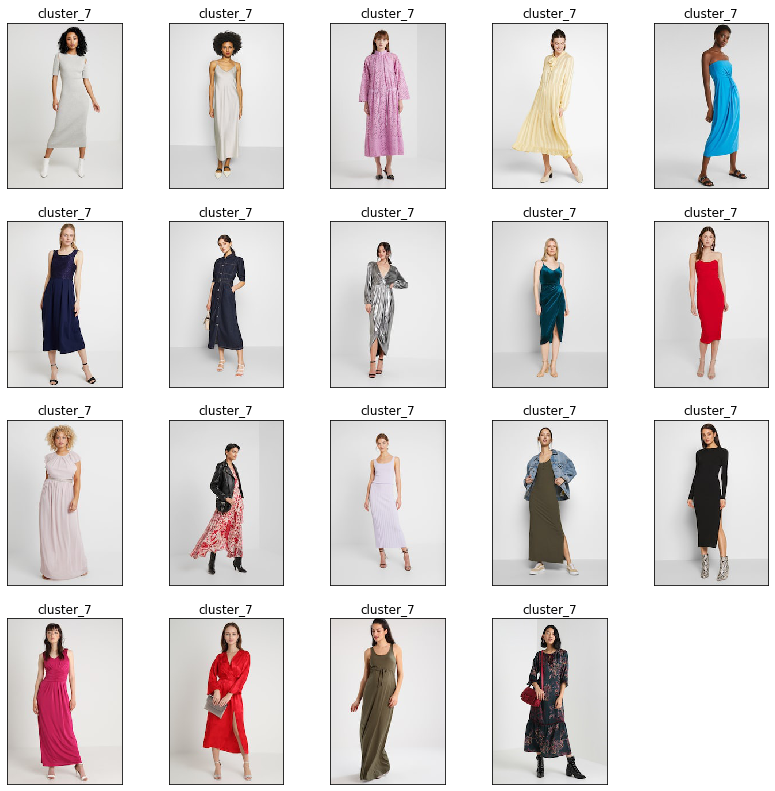

In [109]:
fig = plt.figure(figsize=(14, 14))
cluster_path = '/home/ec2-user/SageMaker/robe_clustering_bis/cluster_7/'
images = [file for file in os.listdir(cluster_path)]

for cnt, data in enumerate(images[1:20]):
#     print(data)
    y = fig.add_subplot(4,5, cnt+1)
    img = mpimg.imread(cluster_path+data) #Read an image from a file into an array.
    y.imshow(img)
    plt.title('cluster_7')
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)

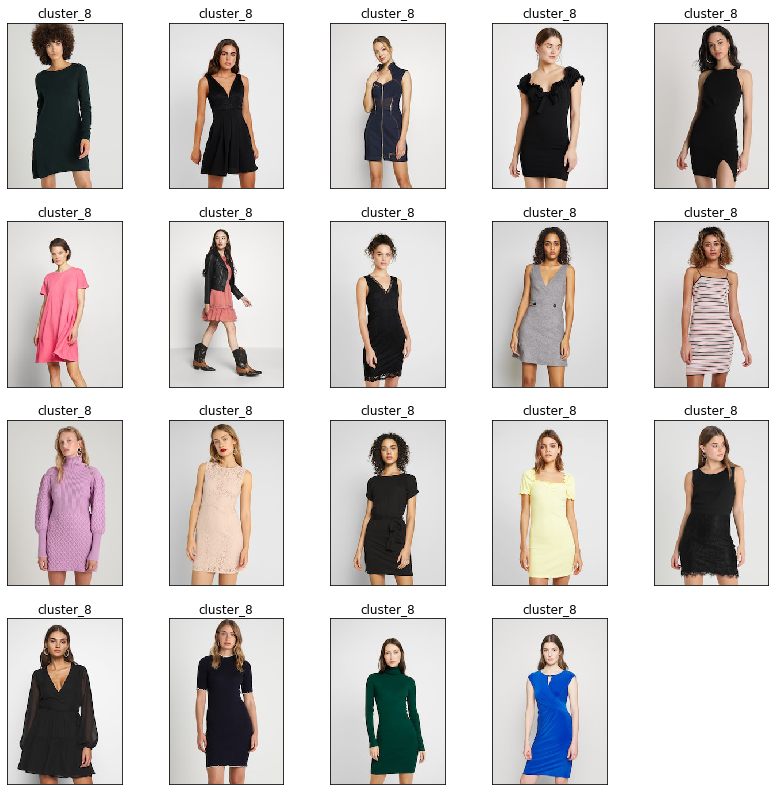

In [110]:
fig = plt.figure(figsize=(14, 14))
cluster_path = '/home/ec2-user/SageMaker/robe_clustering_bis/cluster_8/'
images = [file for file in os.listdir(cluster_path)]

for cnt, data in enumerate(images[1:20]):
#     print(data)
    y = fig.add_subplot(4,5, cnt+1)
    img = mpimg.imread(cluster_path+data) #Read an image from a file into an array.
    y.imshow(img)
    plt.title('cluster_8')
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)

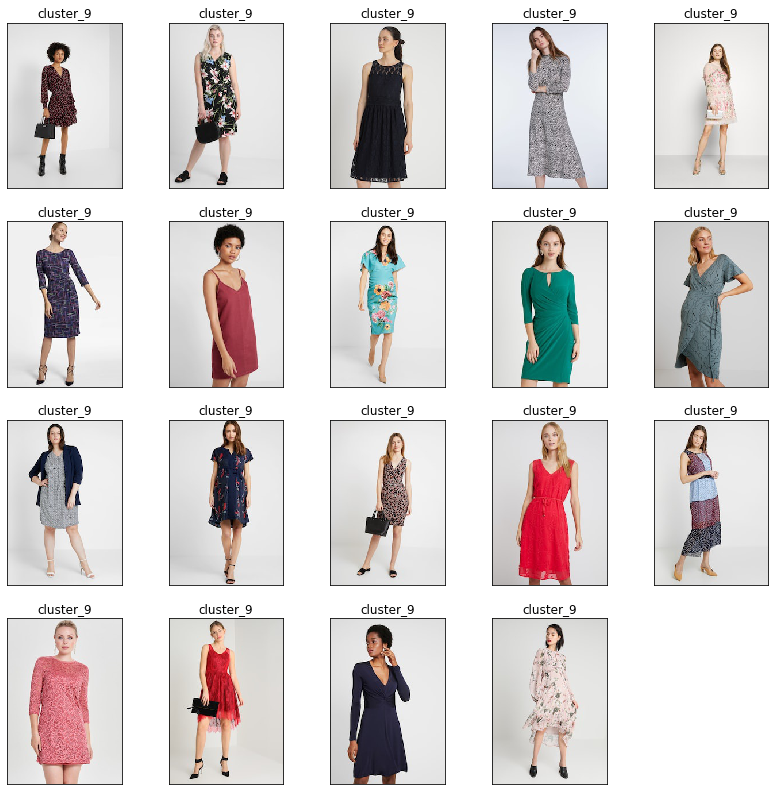

In [112]:
fig = plt.figure(figsize=(14, 14))
cluster_path = '/home/ec2-user/SageMaker/robe_clustering_bis/cluster_9/'
images = [file for file in os.listdir(cluster_path)]

for cnt, data in enumerate(images[1:20]):
#     print(data)
    y = fig.add_subplot(4,5, cnt+1)
    img = mpimg.imread(cluster_path+data) #Read an image from a file into an array.
    y.imshow(img)
    plt.title('cluster_9')
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)

IsADirectoryError: [Errno 21] Is a directory: '/home/ec2-user/SageMaker/robe_clustering_bis/cluster_10/.ipynb_checkpoints'

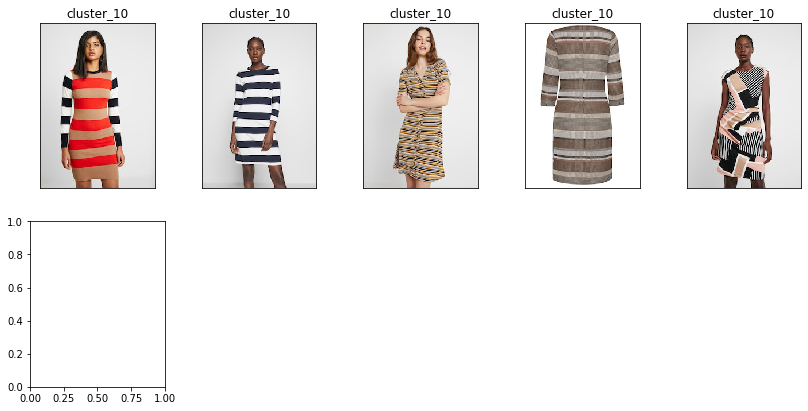

In [134]:
fig = plt.figure(figsize=(14, 14))
cluster_path = '/home/ec2-user/SageMaker/robe_clustering_bis/cluster_10/'
images = [file for file in os.listdir(cluster_path)]

for cnt, data in enumerate(images[1:20]):
#     print(data)
    y = fig.add_subplot(4,5, cnt+1)
    img = mpimg.imread(cluster_path+data) #Read an image from a file into an array.
    y.imshow(img)
    plt.title('cluster_10')
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)

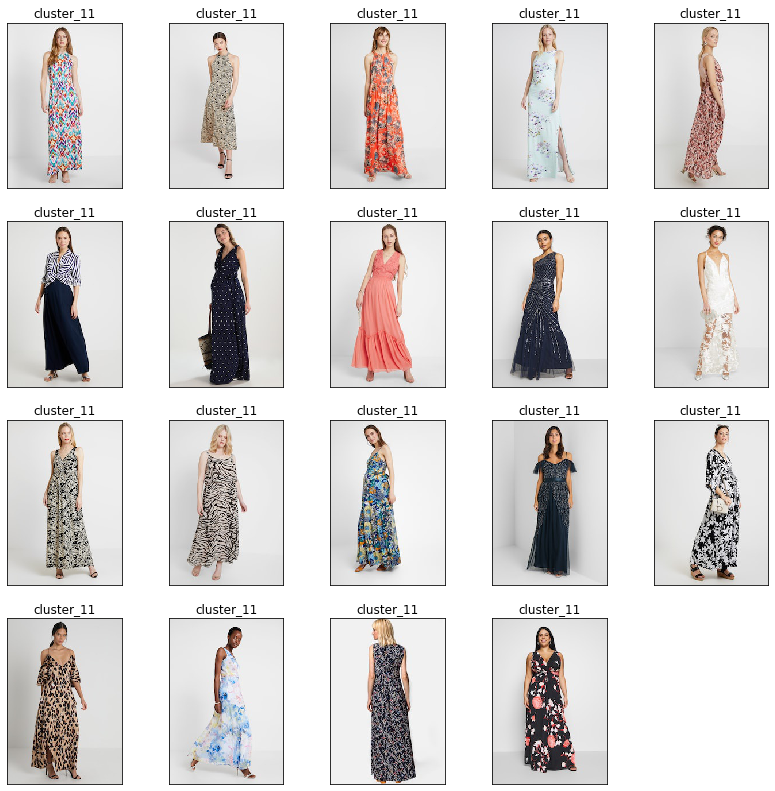

In [120]:
fig = plt.figure(figsize=(14, 14))
cluster_path = '/home/ec2-user/SageMaker/robe_clustering_bis/cluster_11/'
images = [file for file in os.listdir(cluster_path)]

for cnt, data in enumerate(images[1:20]):
#     print(data)
    y = fig.add_subplot(4,5, cnt+1)
    img = mpimg.imread(cluster_path+data) #Read an image from a file into an array.
    y.imshow(img)
    plt.title('cluster_11')
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)

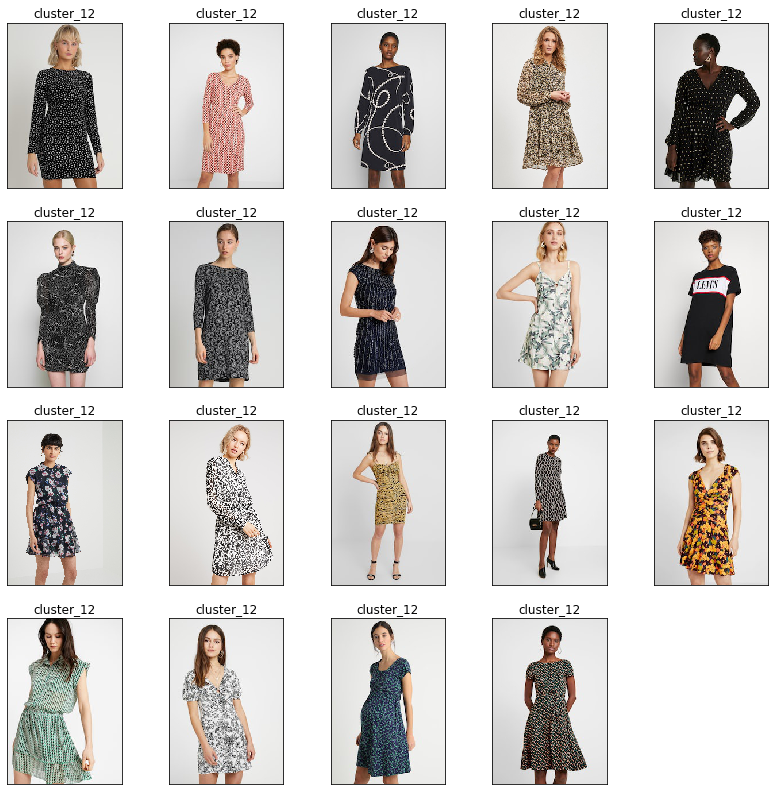

In [121]:
fig = plt.figure(figsize=(14, 14))
cluster_path = '/home/ec2-user/SageMaker/robe_clustering_bis/cluster_12/'
images = [file for file in os.listdir(cluster_path)]

for cnt, data in enumerate(images[1:20]):
#     print(data)
    y = fig.add_subplot(4,5, cnt+1)
    img = mpimg.imread(cluster_path+data) #Read an image from a file into an array.
    y.imshow(img)
    plt.title('cluster_12')
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)